In [1]:
import keras
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import u_net as unet
import skimage.io
import keras.backend as K

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

# Keras related
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Progress bar
from tqdm import tqdm

import random
import warnings

c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set some parameters
IMG_WIDTH = 128*2
IMG_HEIGHT = 128*2
IMG_CHANNELS = 3
TRAIN_PATH = 'data/'
TEST_PATH = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
import os
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
# test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
import sys
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# # Get and resize test images
# X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# sizes_test = []
# print('Getting and resizing test images ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#     path = TEST_PATH + id_
#     img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     sizes_test.append([img.shape[0], img.shape[1]])
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:42<00:00,  9.68it/s]


Done!


c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


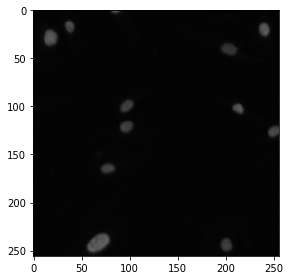

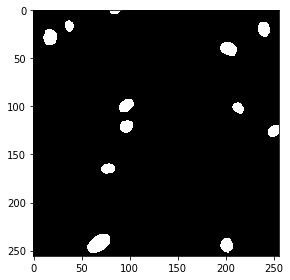

In [5]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [6]:
# Rescale the data
X_train = X_train.astype(float)/255
print(X_train.shape)
print(Y_train.shape)
print(X_train[0])

(670, 256, 256, 3)
(670, 256, 256, 1)
[[[0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.00784314 0.00784314 0.00784314]]

 [[0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.01568627 0.01568627 0.01568627]
  [0.01176471 0.01176471 0.01176471]
  [0.00784314 0.00784314 0.00784314]]

 [[0.02352941 0.02352941 0.02352941]
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.01568627 0.01568627 0.01568627]
  [0.01176471 0.01176471 0.01176471]
  [0.00784314 0.00784314 0.00784314]]

 ...

 [[0.00784314 0.00784314 0.00784314]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]]

 [[0.00784314 0.00784314 0.00784314]

In [7]:
def swish(x):
    return x*K.sigmoid(x)

def e_swish(x):
    return 1.375*x*K.sigmoid(x)

model = unet.u_net(start=32, act="elu")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [ ]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[mean_iou]) # mean_iou

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=4, epochs=20, verbose=1) # callbacks=[earlystopper, checkpointer], 

Train on 603 samples, validate on 67 samples
Epoch 1/20
603/603 [==============================] - ETA: 8:34 - loss: 0.9174 - mean_iou: 0.0000e+ - ETA: 4:29 - loss: 0.8632 - mean_iou: 0.1635   - ETA: 3:08 - loss: 0.8196 - mean_iou: 0.22 - ETA: 2:26 - loss: 0.7882 - mean_iou: 0.25 - ETA: 2:02 - loss: 0.7692 - mean_iou: 0.27 - ETA: 1:45 - loss: 0.7566 - mean_iou: 0.29 - ETA: 1:32 - loss: 0.7475 - mean_iou: 0.30 - ETA: 1:23 - loss: 0.7407 - mean_iou: 0.31 - ETA: 1:16 - loss: 0.7354 - mean_iou: 0.32 - ETA: 1:10 - loss: 0.7312 - mean_iou: 0.33 - ETA: 1:06 - loss: 0.7277 - mean_iou: 0.33 - ETA: 1:02 - loss: 0.7249 - mean_iou: 0.34 - ETA: 58s - loss: 0.7224 - mean_iou: 0.3508 - ETA: 55s - loss: 0.7203 - mean_iou: 0.355 - ETA: 53s - loss: 0.7185 - mean_iou: 0.360 - ETA: 50s - loss: 0.7169 - mean_iou: 0.364 - ETA: 48s - loss: 0.7155 - mean_iou: 0.368 - ETA: 46s - loss: 0.7143 - mean_iou: 0.372 - ETA: 45s - loss: 0.7132 - mean_iou: 0.374 - ETA: 43s - loss: 0.7122 - mean_iou: 0.377 - ETA: 42s - l

603/603 [==============================] - ETA: 24s - loss: 0.6931 - mean_iou: 0.425 - ETA: 23s - loss: 0.6931 - mean_iou: 0.425 - ETA: 23s - loss: 0.6931 - mean_iou: 0.424 - ETA: 23s - loss: 0.6931 - mean_iou: 0.424 - ETA: 23s - loss: 0.6931 - mean_iou: 0.424 - ETA: 23s - loss: 0.6931 - mean_iou: 0.424 - ETA: 23s - loss: 0.6931 - mean_iou: 0.424 - ETA: 23s - loss: 0.6931 - mean_iou: 0.424 - ETA: 22s - loss: 0.6931 - mean_iou: 0.424 - ETA: 22s - loss: 0.6931 - mean_iou: 0.424 - ETA: 22s - loss: 0.6931 - mean_iou: 0.424 - ETA: 22s - loss: 0.6931 - mean_iou: 0.424 - ETA: 22s - loss: 0.6931 - mean_iou: 0.424 - ETA: 22s - loss: 0.6931 - mean_iou: 0.424 - ETA: 22s - loss: 0.6931 - mean_iou: 0.424 - ETA: 21s - loss: 0.6931 - mean_iou: 0.424 - ETA: 21s - loss: 0.6931 - mean_iou: 0.424 - ETA: 21s - loss: 0.6931 - mean_iou: 0.424 - ETA: 21s - loss: 0.6931 - mean_iou: 0.424 - ETA: 21s - loss: 0.6931 - mean_iou: 0.424 - ETA: 21s - loss: 0.6931 - mean_iou: 0.424 - ETA: 21s - loss: 0.6931 - mean_io

603/603 [==============================] - ETA: 24s - loss: 0.6931 - mean_iou: 0.424 - ETA: 24s - loss: 0.6931 - mean_iou: 0.424 - ETA: 23s - loss: 0.6931 - mean_iou: 0.424 - ETA: 23s - loss: 0.6931 - mean_iou: 0.424 - ETA: 23s - loss: 0.6931 - mean_iou: 0.425 - ETA: 23s - loss: 0.6931 - mean_iou: 0.425 - ETA: 23s - loss: 0.6931 - mean_iou: 0.425 - ETA: 23s - loss: 0.6931 - mean_iou: 0.425 - ETA: 23s - loss: 0.6931 - mean_iou: 0.425 - ETA: 22s - loss: 0.6931 - mean_iou: 0.425 - ETA: 22s - loss: 0.6931 - mean_iou: 0.425 - ETA: 22s - loss: 0.6931 - mean_iou: 0.425 - ETA: 22s - loss: 0.6931 - mean_iou: 0.425 - ETA: 22s - loss: 0.6931 - mean_iou: 0.425 - ETA: 22s - loss: 0.6931 - mean_iou: 0.425 - ETA: 22s - loss: 0.6931 - mean_iou: 0.425 - ETA: 21s - loss: 0.6931 - mean_iou: 0.425 - ETA: 21s - loss: 0.6931 - mean_iou: 0.425 - ETA: 21s - loss: 0.6931 - mean_iou: 0.425 - ETA: 21s - loss: 0.6931 - mean_iou: 0.425 - ETA: 21s - loss: 0.6931 - mean_iou: 0.425 - ETA: 21s - loss: 0.6931 - mean_io

284/603 [=============>................] - ETA: 24s - loss: 0.6931 - mean_iou: 0.424 - ETA: 25s - loss: 0.6931 - mean_iou: 0.424 - ETA: 25s - loss: 0.6931 - mean_iou: 0.424 - ETA: 24s - loss: 0.6931 - mean_iou: 0.424 - ETA: 24s - loss: 0.6931 - mean_iou: 0.424 - ETA: 24s - loss: 0.6931 - mean_iou: 0.424 - ETA: 24s - loss: 0.6931 - mean_iou: 0.424 - ETA: 23s - loss: 0.6931 - mean_iou: 0.424 - ETA: 23s - loss: 0.6931 - mean_iou: 0.424 - ETA: 23s - loss: 0.6931 - mean_iou: 0.424 - ETA: 23s - loss: 0.6931 - mean_iou: 0.424 - ETA: 23s - loss: 0.6931 - mean_iou: 0.424 - ETA: 23s - loss: 0.6931 - mean_iou: 0.424 - ETA: 22s - loss: 0.6931 - mean_iou: 0.424 - ETA: 22s - loss: 0.6931 - mean_iou: 0.424 - ETA: 22s - loss: 0.6931 - mean_iou: 0.424 - ETA: 22s - loss: 0.6931 - mean_iou: 0.424 - ETA: 22s - loss: 0.6931 - mean_iou: 0.424 - ETA: 22s - loss: 0.6931 - mean_iou: 0.424 - ETA: 21s - loss: 0.6931 - mean_iou: 0.424 - ETA: 21s - loss: 0.6931 - mean_iou: 0.424 - ETA: 21s - loss: 0.6931 - mean_io

In [11]:
# Predict on train set
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)

603/603 [==============================] - ETA: 17 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 9ms/step


c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


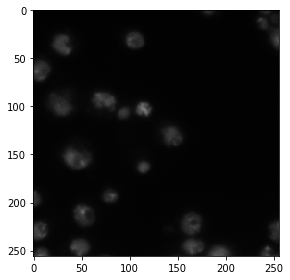

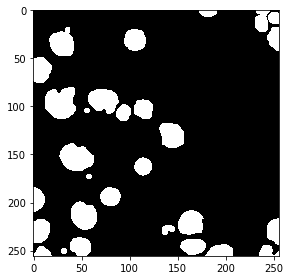

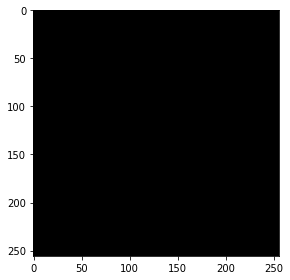

In [12]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()